##Topic : Independent Component Analysis

**Import required libraries**

In [ ]:
import os
import IPython
import cv2 as cv
import numpy as np
import seaborn as sns
import pandas as pd 
from scipy.io import wavfile 
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
%matplotlib inline

**Algorithm Implementation**

In [ ]:
def Datacentering( X : np.ndarray ):   
    """
    Make mean of each dependent component of input matrix X  zero (0). 
    """
    means = np.mean( X, axis=1, keepdims=True )
    Datacentered = X - means
    return Datacentered 

In [ ]:
def Decomposeigen( X : np.ndarray ):  
    """
    Find eigne values and eigne values of covariance matrix of centered Data.
    """
    covarianceMatrix =  np.cov( X )
    try : 
        eigValues, eigVectors = np.linalg.eig( covarianceMatrix )
    except Exception as e : 
        print( "Error : ", e)
        return 

    return eigVectors , np.diag(eigValues),

In [ ]:
def Datawhitening( X : np.ndarray ) : 
    """
    Find linear transformation L s.t. L@X is uncorrelated matrix with variance identity matrix  
    """
    E, D = Decomposeigen( X )
    L = np.linalg.inv( D**(1/2) ) @ E.T 
    whitenedData   = L@X 
    return L, whitenedData 

In [ ]:
def g( u  : np.ndarray , method= 1 ):
    if method == 1 :    
        gu =  np.tanh( u )

    if method == 2 : 
        gu =  u * np.exp( -u**2/2 )
    
    return gu

In [ ]:
def g_derivative( u : np.ndarray, method= 1):
    if method == 1 : 
        grad =  1 - np.square( np.tanh(u) )
    
    if method == 2 : 
        grad = ( 1- u**2 )* np.exp( -u**2/2 )
    
    return grad  

In [ ]:
def Sourcesrecover( V , origData, Datawhitening, Filterwhiten, isImage=False ):

    # project whitened data onto independent components:
    S = np.matmul(V, Datawhitening )

    # compute unmixing matrix:
    W = np.matmul(V,Filterwhiten)

    # estimate the mean and standard deviation of the sources:
    S_mean = np.matmul(W, np.mean(origData, axis=1, keepdims=True))
    S_std = np.matmul(V, np.std(origData, axis=1, keepdims=True))

    # add the mean and standard deviation of the sources back in:
    S = S_std * S + S_mean
    
    if isImage : 
        return S 
    
    S = np.int16(S)
    return S

In [ ]:
def ICAfast( X : np.ndarray, N, M, C ): 

    np.random.seed(42)   # For reproducability of code

    W = np.zeros((N,C))    
    epsilon = 1e-10
    for p in range(0, C): 
        Wp = np.random.randn(N,1)
        iteration = 0 
        max_iterations = 200
        while iteration < max_iterations : 
            Wp =   (1./M) * ( X @ ( g ( Wp.T @ X ).T ) - g_derivative( Wp.T @ X ) @ np.ones( (M,1) ) * Wp ) 
            Wp -=  np.sum( [ np.dot(np.squeeze(Wp), W[:, k]) * np.reshape(W[:, k], (N, 1)) for k in range(p) ], axis=0)
            Wp = Wp / np.linalg.norm(Wp)
            W[ :, p ] = Wp.reshape(-1) 
            iteration += 1     
    V = W.T 
    return V 

**Getting Independent Sound signals from mixed signals using ICA**

In [ ]:
def getSoundFiles(folderName="sound_files"):
    sound_signals = []
    sound_files = []
    for  root, _ ,  files in os.walk(folderName): 
        for sound_file in files : 
            path = root + "/" + sound_file 
            rate , mixed_signal = wavfile.read( path )
            sound_signals.append(mixed_signal)      
            sound_files.append( path)


    n = min( [ len(x) for x in sound_signals ] ) 
    sound_signals = np.array( [ signal[:n] for signal in sound_signals ] )
    return sound_files, sound_signals

In [ ]:
def plotSignals(sound_signals): 
    for j in range(len(sound_signals)):
        n = len(sound_signals[0])
        plt.figure(figsize=(12,2))
        plt.title('Recording %d'%(j+1))
        plt.plot(range(n), sound_signals[j,:], c="#3ABFE7")
        plt.ylim(-35000, 35000)

In [ ]:
def showAudio(sound_files): 
    for i in range(len(sound_files)): 
        print("Audio %d"%(i+1))
        IPython.display.display(IPython.display.Audio(sound_files[i]))

In [ ]:
def writeOutput( S , path="recovered_files/sound_seperated_"): 
    output = [ path +str(i+1)+".wav" for i in range(len(S)) ]
    for i in range( len (output )): 
        wavfile.write(output[i], rate=32000, data=S[i,:])
    return output

In [ ]:
def Algorithm( sound_signals, returnUnmixingMatrix = False, isImage=False): 
    origData = sound_signals    # X is input signal matrix of shape N x M 
    N = origData.shape[0]       # Number of columns corresponding with the number of samples of in each mixed signals 
    M = origData.shape[1]       # Number of rows corresponding with the number of independent source signals
    C = origData.shape[0]       # Number of desired independent components 

    centeredData = Datacentering(origData)
    whitenFilter, whitenedData = Datawhitening(centeredData)
    V = ICAfast( whitenedData ,N, M , C ) 
    S = Sourcesrecover(V, origData, whitenedData, whitenFilter, isImage)  # source signals 
    unmixingMatrix = V@whitenFilter 
    if returnUnmixingMatrix : 
        return unmixingMatrix, S 
    return S 

**Application 1 : Seperating Mixed Signals into their independent components**

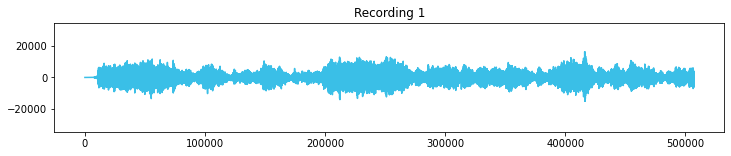

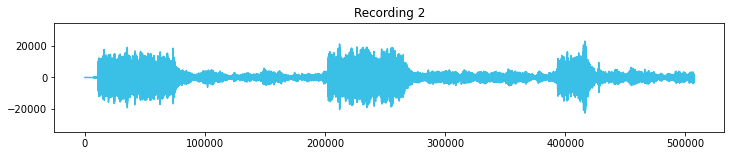

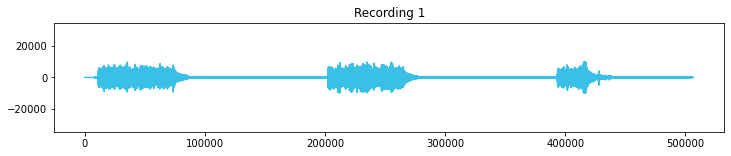

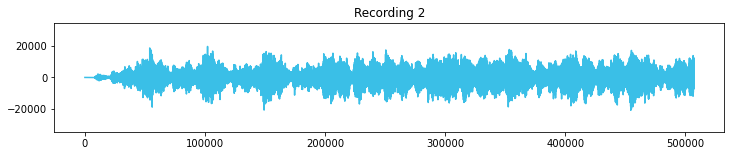

In [ ]:
# Read sound files 
sound_files, sound_signals = getSoundFiles("sound_files")

# Visualize signals 
plotSignals(sound_signals)

# Perform ICA 
S = Algorithm(sound_signals )

# Visualize output 
plotSignals(S)

# Write output to WAV format file 
output_sound_files = writeOutput(S)

**Application 2 : Seperating Non-signal data mixed together**

In [ ]:
# let's take a mixture of two independent images
img1 = cv.imread('./animals/dog1.png')
img2 = cv.imread('./animals/cat1.png')

img1 = cv.resize( img1, (500,500)).reshape(-1)/255
img2 = cv.resize( img2, (500,500)).reshape(-1)/255

sourceImages = np.vstack([img1,img2])

In [ ]:
# Mixing Matrix W 
np.random.seed(42)
W = np.random.rand(2, 2)
mixedImages = W @ sourceImages

cv.imshow( "Merged Image 1", mixedImages[0].reshape( (500,500,3)))
cv.imshow( "Merged Image 2", mixedImages[1].reshape( (500,500,3)))

cv.waitKey(0)
cv.destroyAllWindows()

**Check if Images are Independent**

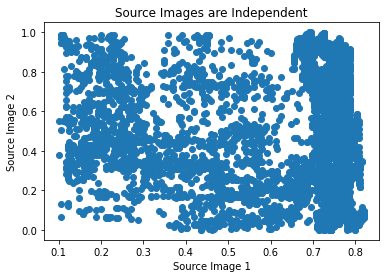

In [ ]:
plt.title("Source Images are Independent")
plt.scatter(sourceImages[0][np.arange(0,750000,100)], sourceImages[1][np.arange(0,750000,100)])
plt.xlabel("Source Image 1")
plt.ylabel("Source Image 2")
plt.show()

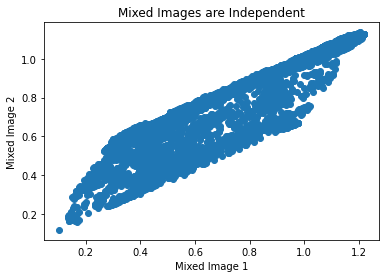

In [ ]:
plt.title("Mixed Images are Independent")
plt.scatter(mixedImages[0][np.arange(0,750000,100)], mixedImages[1][np.arange(0,750000,100)])
plt.xlabel("Mixed Image 1")
plt.ylabel("Mixed Image 2")
plt.show()

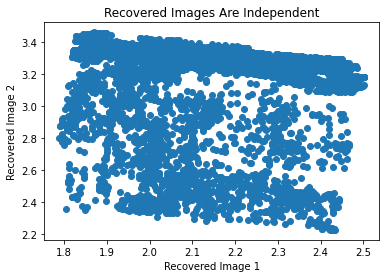

In [ ]:
recoveredImages = Algorithm(mixedImages, isImage=True)

plt.title("Recovered Images Are Independent")
plt.scatter(recoveredImages[0][np.arange(0,750000,100)], recoveredImages[1][np.arange(0,750000,100)])
plt.xlabel("Recovered Image 1")
plt.ylabel("Recovered Image 2")
plt.show()

# To rescale pixels between 0 & 1 
recoveredImages = recoveredImages/np.max( recoveredImages, axis=1, keepdims=True)

In [ ]:
cv.imshow( "Recovered Image 1", recoveredImages[0].reshape((500,500,3)))
cv.imshow( "Recovered Image 2", recoveredImages[1].reshape((500,500,3)))

cv.waitKey(0)
cv.destroyAllWindows()